<a href="https://colab.research.google.com/github/lapshinaaa/homework_DeepLearning/blob/main/homework_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-08 06:57:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [          <=>       ] 201.24M  31.3MB/s    in 6.1s    

2023-10-08 06:57:47 (32.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
# checking for any missing values:
df.isnull().values.any() # output: False -> no missing values found

False

In [6]:
from sklearn.preprocessing import StandardScaler

# creating an instance of a Scaler
scaler = StandardScaler()

# scaling all the numerical features:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# taking a look at the results:
X_train_df = pd.DataFrame(X_train)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.078786,0.391566,1.826962,0.466361,-0.476621,-0.275266,-1.551924,-1.311105,0.389093,-0.665402,...,-0.084995,0.106413,0.144257,-0.236180,0.047430,-0.355855,0.544084,-0.470477,-0.255366,0.042637
1,0.879511,0.332631,1.748961,0.723345,-0.166769,-1.189729,0.764797,0.109714,1.422683,0.416934,...,-0.314004,0.304413,-0.068758,0.053729,-0.634467,-0.435794,0.556059,0.570861,0.209341,1.161118
2,1.245515,0.592771,1.337550,0.752153,-0.002899,-0.699856,-0.061323,-0.069912,1.167910,-0.073176,...,-0.395974,0.565220,-0.758259,-0.282931,-0.026058,0.223918,-0.508889,-0.338081,0.107828,-0.090122
3,0.799787,-0.061214,0.784000,0.089197,0.327463,-1.297159,0.509977,-1.073557,-0.015553,-1.262565,...,0.586855,-0.562444,-0.479423,-0.890199,-0.796124,0.568335,-0.262505,0.409924,0.973205,0.795200
4,1.247663,0.793377,1.657449,0.449177,-0.408652,-0.564673,-0.692545,-0.952369,0.843389,-0.143557,...,-0.181284,0.097564,0.192974,-0.585048,-0.113758,-0.219524,0.448546,0.258400,0.194381,1.244057


In [7]:
def set_random_seed(seed):
    # setting random seed for PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # disabling the in-built cudnn
                                           # auto-tuner for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # setting random seed for NumPy
    np.random.seed(seed)

    # setting random seed for Python 'random' module
    random.seed(seed)

**Sourse of information regarding the added line with disabling the in-built cudnn for better reproducibility: ** https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936

In [8]:
set_random_seed(42)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# creating an instance of a Ridge regressor and training the model
model = Ridge()
model.fit(X_train, y_train)

# making predictions on the test data:
y_pred = model.predict(X_test)

# calculating RMSE for the results and printing it out
rmse_for_model = mean_squared_error(y_pred, y_test, squared=False)
print(f'RMSE for the trained Ridge model is: {rmse_for_model}')

RMSE for the trained Ridge model is: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
# calculating the mean:
y_mean = y_train.mean() # this mean represents the average release year of the songs in the training dataset
constant_predictions = [y_mean] * len(y_test)

# calculating and printing out the results
best_rmse_metric = mean_squared_error(constant_predictions, y_test, squared=False)
print(f'RMSE for the constant prediction is: {best_rmse_metric}')

RMSE for the constant prediction is: 10.85246390513634


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
# creating a model with only one Linear layer (I'll be using the first one
# of the methods from the previous seminar)

class LinearModel(nn.Module):
  """Simple Class for creating
    Linear Regression models"""

  # constructor for the class
  def __init__(self, input_size, output_size):
    super(LinearModel, self).__init__()
    self.linear = nn.Linear(input_size, output_size)
   # self.double()

  # method for forward pass:
  def forward(self, x):
    return self.linear(x)

linear_regression_model = LinearModel(90, 1)

In [12]:
linear_regression_model.to(device)

LinearModel(
  (linear): Linear(in_features=90, out_features=1, bias=True)
)

In [13]:
set_random_seed(34)

In [14]:
from torch.utils.data import DataLoader, TensorDataset

# combining train and test data for further exploitation
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# Initializing data loaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=1)

In [ ]:
# checking of we receive random batches correctly
batch = next(iter(train_dataloader))

#print(f"Sample:\n{batch}")

In [16]:
# functions for calculating losses
def root_mean_squared_error(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    mean_squared_error = torch.mean(squared_error)
    return torch.sqrt(mean_squared_error)

# def mean_squared_error(y_pred, y_true):
#     squared_error = (y_pred - y_true) ** 2
#     mean_squared_error = torch.mean(squared_error)
#     return mean_squared_error

In [18]:
num_epochs = 10
learning_rate = 0.01

# storing losses for plotting the data afterwards
train_losses = []
val_losses_track = []

# loop for training a linear regression model
for epoch in range(num_epochs):
    for x_train, y_train in tqdm(train_dataloader):  # taking a batch from a dataloader
        x_train = x_train.to(device, dtype=torch.float32)  # converting input data to float32
        y_train = y_train.to(device, dtype=torch.float32)  # converting target data to float32
        y_pred = linear_regression_model(x_train)  # forward pass
        loss = root_mean_squared_error(y_pred, y_train)  # calculating RMSE

        # doing a backward pass:
        loss.backward()

        # manual implementation of an optimizer (SGD):
        with torch.no_grad():
            for parameter in linear_regression_model.parameters():
            #    torch.nn.utils.clip_grad_norm_(linear_regression_model.parameters(), max_norm=1.0)
                parameter.data = parameter.data - learning_rate * parameter.grad
                parameter.grad.zero_()  # zeroing out gradients

        train_losses.append(loss.item())

    # evaluating the model during each epoch (according to the task):
    with torch.no_grad():
        val_losses = []
        for x_val, y_val in tqdm(val_dataloader):  # taking a batch from a dataloader
            x_val = x_val.to(device, dtype=torch.float32)  # converting input data to float32
            y_val = y_val.to(device, dtype=torch.float32)  # converting target data to float32
            y_pred_val = linear_regression_model(x_val)
            loss = root_mean_squared_error(y_pred_val, y_val)
            val_losses.append(loss.cpu().numpy())  # appending loss values
            val_losses_track.append(loss.cpu().numpy())

    print(f"Epoch: {epoch + 1}, loss: {np.mean(val_losses)}")

  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 1, loss: 1221.325927734375


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 2, loss: 757.0135498046875


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 3, loss: 292.8687744140625


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 4, loss: 8.515392303466797


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 5, loss: 8.603169441223145


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 6, loss: 8.552847862243652


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 7, loss: 8.549838066101074


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 8, loss: 8.572365760803223


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 9, loss: 8.575886726379395


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 10, loss: 8.536171913146973


**ATTENTION!** While completing the task above, I've encountered the following error multiple times: "mat1 and mat2 must have the same dtype". Editing the custom RMSE function as well as converting the data to float32 helped to solve it. The solution was found here: https://stackoverflow.com/questions/75102134/mat1-and-mat2-must-have-the-same-dtype

In [74]:
from scipy.interpolate import make_interp_spline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

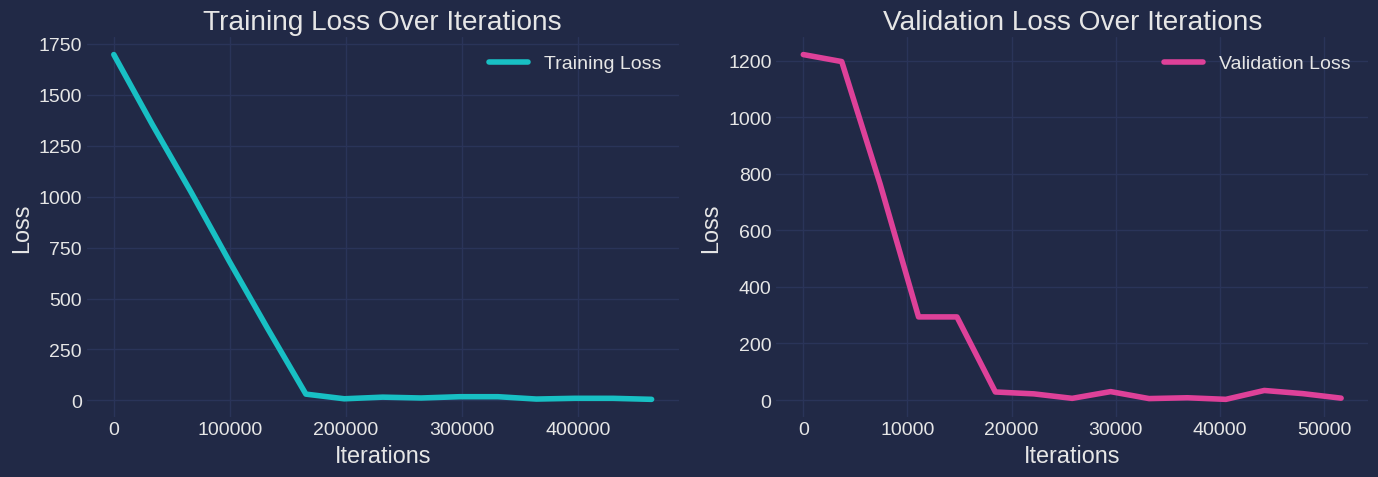

In [77]:
# Create an array for the x-axis representing the number of iterations (assuming each batch as an iteration)
x_train_iterations = range(len(train_losses))
x_val_iterations = range(len(val_losses_track))

# Define the number of points for the smooth curve
num_smooth_points = 15

# Create a smoothed curve for training and validation losses using B-spline interpolation
spline = make_interp_spline(x_train_iterations, train_losses)
x_train_smoothed = np.linspace(x_train_iterations[0], x_train_iterations[-1], num=num_smooth_points)
smoothed_train_losses = spline(x_train_smoothed)

spline = make_interp_spline(x_val_iterations, val_losses_track)
x_val_smoothed = np.linspace(x_val_iterations[0], x_val_iterations[-1], num=num_smooth_points)
smoothed_val_losses = spline(x_val_smoothed)

# Create separate plots for training and validation losses
plt.figure(figsize=(14, 5))

# Plot the smoothed training loss
plt.subplot(1, 2, 1)
plt.plot(x_train_smoothed, smoothed_train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Over Iterations")

# Plot the smoothed validation loss
plt.subplot(1, 2, 2)
plt.plot(x_val_smoothed, smoothed_val_losses, label="Validation Loss", color='#DE4199')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Validation Loss Over Iterations")

# Adjust layout for the subplots
plt.tight_layout()

# Show the plots
plt.show()

**Credits:** the styles for the plots were found on: https://github.com/dhaitz/matplotlib-stylesheets#pitaya-smoothie-dark

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
train_set = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

model = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    raise NotImplementedError


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    predicts = torch.ones(len(test_loader.dataset))
    return predicts


In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

In [ ]:
# ೭੧(❛〜❛✿)੭೨ Go forward!

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.